<a href="https://colab.research.google.com/github/yeyni2/car-price-prediction/blob/main/signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import glob
import tensorflow as tf
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline  
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,Dropout, Flatten, Activation, RandomFlip, RandomRotation, Resizing, Rescaling, experimental
from keras.layers import concatenate, Lambda, Embedding, Input
import random

In [ ]:
true_signature = {}
true_signature["Itzik Yeyni"] = []
true_signature["Or Yeyni"] = []
true_signature["Shalev Yeyni"] = []
true_signature["Tamar Founis"] = []
true_signature["Eyal Moskowitz"] = []
true_signature["Roni Waltman"] = []
true_signature["Adina Waltman"] = []
true_signature["Liran Yeyni"] = []

In [ ]:
def make_data(name, lst):
  name2 = name.split(' ')
  a = '/content/drive/MyDrive/'+name2[0]+name2[1]+'/*.jpeg'
  for img in glob.glob(a):
    img2 = tf.keras.preprocessing.image.load_img(img, target_size = (160,160))
    img2 = np.around(np.array(img2) / 255.0, decimals=12)
    lst[name].append(img2)

In [ ]:
for i in true_signature:
  make_data(i, true_signature)

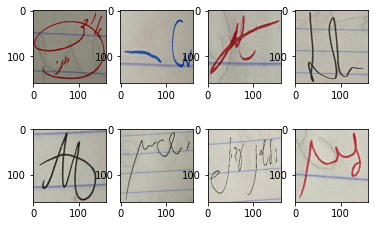

In [ ]:
x = 1
for i in true_signature:
  num = random.randint(0,5)
  ax = plt.subplot(2, 4, x)
  plt.imshow(true_signature[i][num])
  x+=1


In [ ]:
fake_signature = []
for img in glob.glob('/content/drive/MyDrive/FakeSignature2/*.jpeg'):
  img2 = tf.keras.preprocessing.image.load_img(img, target_size = (160,160))
  img2 = np.around(np.array(img2) / 255.0, decimals=12)
  #img2 = tf.expand_dims(img2, 0)
  fake_signature.append(img2)

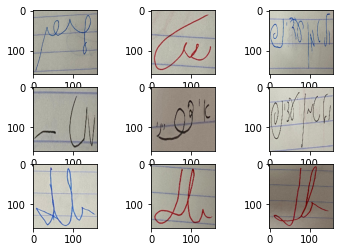

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, 1+i)
  num = random.randint(0,len(fake_signature)-1)
  plt.imshow(fake_signature[num])

In [ ]:
anchor = []
positive = []
negative = []

In [ ]:
for per in true_signature:
  for i in range(6):
    for j in range(6):
      if j != i:
        for g in range(len(fake_signature)):
          anchor.append(np.expand_dims(true_signature[per][i], 0))
          positive.append(np.expand_dims(true_signature[per][j], 0))
          negative.append(np.expand_dims(fake_signature[g],0))
      for per2 in true_signature:
        if per2 != per:
          for p in range(6):
            anchor.append(np.expand_dims(true_signature[per][i], 0))
            positive.append(np.expand_dims(true_signature[per][j], 0))
            negative.append(np.expand_dims(true_signature[per2][p], 0))


In [ ]:
if len(anchor) == len(positive) == len(negative):
  print("There are " + str(len(anchor)) + " trainig examples")

There are 52896 trainig examples


In [ ]:
def gen_batch(batch_size = 64):
  while True:
    a = []
    p = []
    n = []
    for i in range(batch_size):
      num = random.randint(0, len(anchor)-1)
      a.append(anchor[num])
      p.append(positive[num])
      n.append(negative[num])
      yield [a[i],p[i],n[i]], np.zeros((batch_size, 1)).astype("float32")


In [ ]:
def triplet_loss(y_true, y_pred, margin =0.4):
    anchor, positive, negative = y_pred[:, 0:128], y_pred[:, 128:256], y_pred[:, 256:384]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.reduce_mean(tf.maximum(basic_loss,0))
    return loss

In [ ]:
def make_model(input_shape):
   inputs = keras.Input(shape = input_shape)
   x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
   x = layers.MaxPooling2D((2, 2))(x)
   x = layers.BatchNormalization()(x)
   x = layers.Dropout(0.2)(x)


   x = layers.Conv2D(64, (3, 3),strides = 1, padding = 'same', activation = 'relu')(x)
   x = layers.Conv2D(64, 3,strides = 1, padding = 'same', activation = 'relu')(x)
   x = layers.MaxPooling2D((2, 2))(x)
   x = layers.BatchNormalization()(x)
   x = layers.Dropout(0.2)(x)

   x = layers.Conv2D(128, (3, 3),strides = 1, padding = 'same', activation = 'relu')(x)
   x = layers.MaxPooling2D((2, 2))(x)
   x = layers.BatchNormalization()(x)
   
   x = layers.Conv2D(256, (3, 3),strides = 1, padding = 'same', activation = 'relu')(x)
   x = layers.MaxPooling2D((2, 2))(x)
   x = layers.BatchNormalization()(x)

   x = layers.Conv2D(512, 3,strides = 1, padding = 'same', activation = 'relu')(x)
   x = layers.MaxPooling2D((2, 2))(x)
   x = layers.BatchNormalization()(x)
   x = layers.Dropout(0.2)(x)

   #x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
   x = layers.Flatten()(x)# היה אחרי הכל
   x = layers.Dense(512, activation='sigmoid')(x)
   x = layers.Dropout(0.2)(x)
   x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
   outputs = layers.Dense(128, activation='softmax')(x)
   return keras.Model(inputs, outputs)

In [ ]:
model = make_model((160, 160, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                          

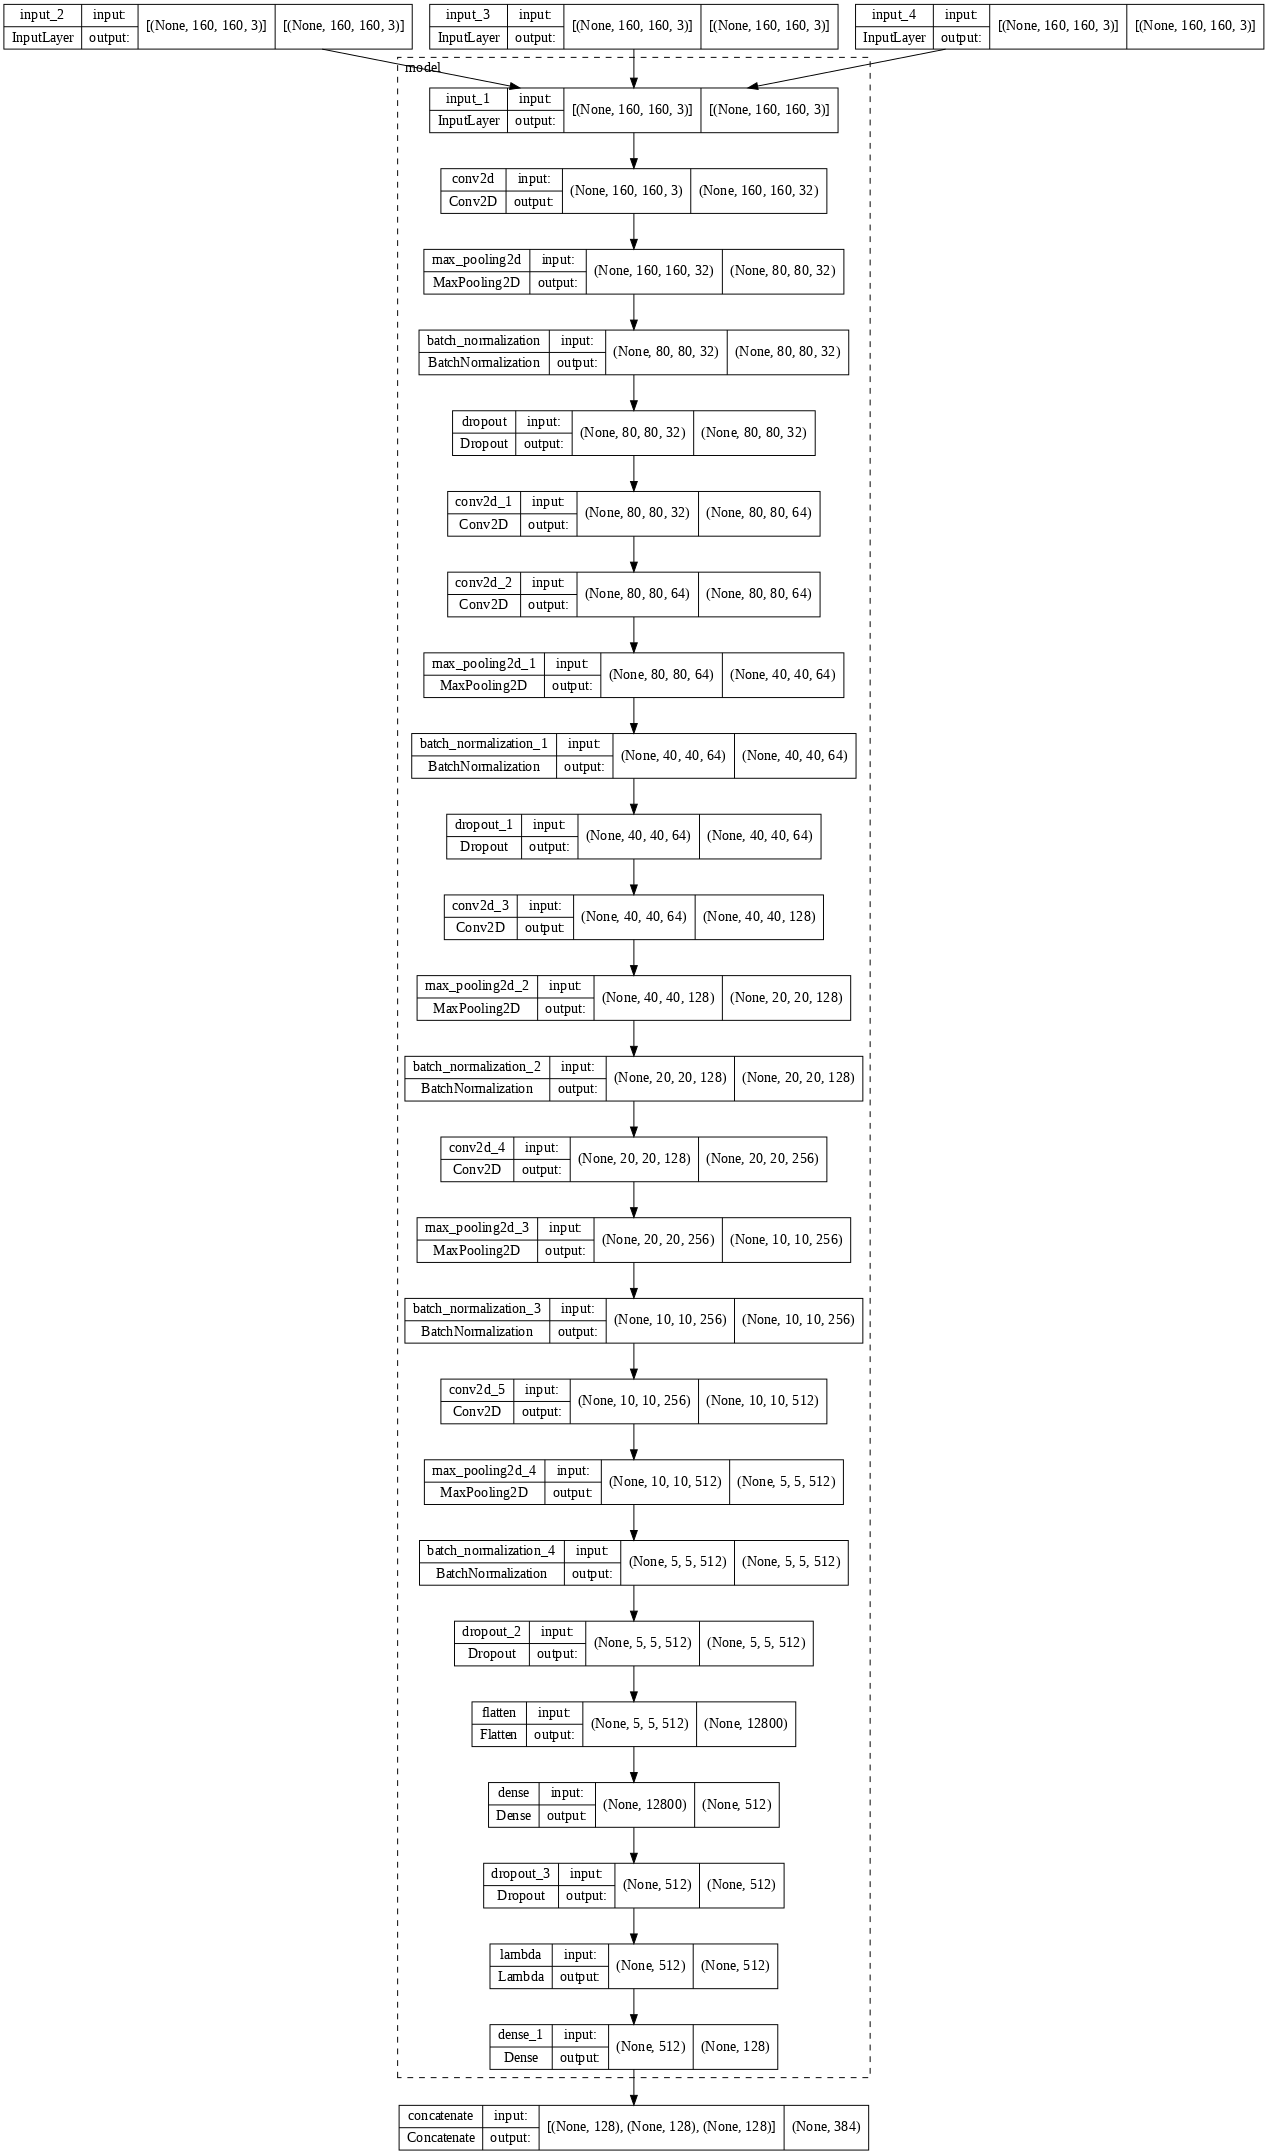

In [ ]:
from keras.layers.merge import Concatenate
triplet_model_anchor = Input((160,160, 3))
triplet_model_positive = Input((160, 160, 3))
triplet_model_negative = Input((160, 160, 3))
triplet_model_out = Concatenate()([model(triplet_model_anchor), model(triplet_model_positive), model(triplet_model_negative)])
triplet_model = keras.Model([triplet_model_anchor, triplet_model_positive, triplet_model_negative], triplet_model_out)
triplet_model.summary()
display(tf.keras.utils.plot_model(triplet_model, dpi = 70, show_shapes = True, expand_nested = True))

In [ ]:
triplet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = triplet_loss)

In [ ]:
history = triplet_model.fit(gen_batch(64), steps_per_epoch = 500, epochs = 200)

Epoch 1/300
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0193
Epoch 2/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0178
Epoch 3/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0139
Epoch 4/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0162
Epoch 5/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0128
Epoch 6/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0191
Epoch 7/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0137
Epoch 8/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0147
Epoch 9/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0176
Epoch 10/300
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0151
Epoch 11/300
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0120
Epoch 12/300
1000/1000 [============================

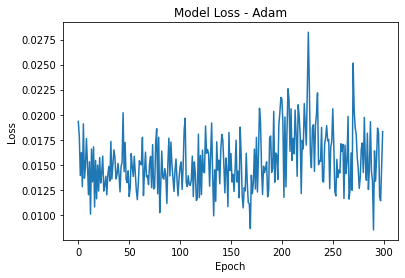

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss - Adam')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
#model.save("/content/drive/MyDrive/best_model")

In [ ]:
FRmodel = tf.keras.models.load_model('/content/drive/MyDrive/facenet_keras.h5')
FRmodel.load_weights('/content/drive/MyDrive/facenet_keras_weights2.h5')
FRmodel.trainable = False
FRmodel.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [ ]:
x = img_to_encoding('/content/drive/MyDrive/WhatsApp Image 2022-02-22 at 18.18.40.jpeg', FRmodel)
y = img_to_encoding('/content/drive/MyDrive/WhatsApp Image 2022-02-22 at 18.18.40 (1).jpeg', FRmodel)
z = img_to_encoding('/content/drive/MyDrive/WhatsApp Image 2022-02-22 at 18.20.53.jpeg', FRmodel)
print("lets see if the face net model works on faces first")
print("should be small " )
print(np.linalg.norm(y - z), np.sum(np.square(y - z), axis=-1))
print()
print("should be big" )
print( np.linalg.norm(y - x), np.sum(np.square(y - x), axis=-1))

lets see if the face net model works on faces first
should be small 
7.866513 [61.88203]

should be big
10.074357 [101.49267]


In [ ]:
triplet_loss2([y,z,x])

tf.Tensor([61.882027], shape=(1,), dtype=float32)
tf.Tensor([101.492676], shape=(1,), dtype=float32)
tf.Tensor([-39.210648], shape=(1,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                          

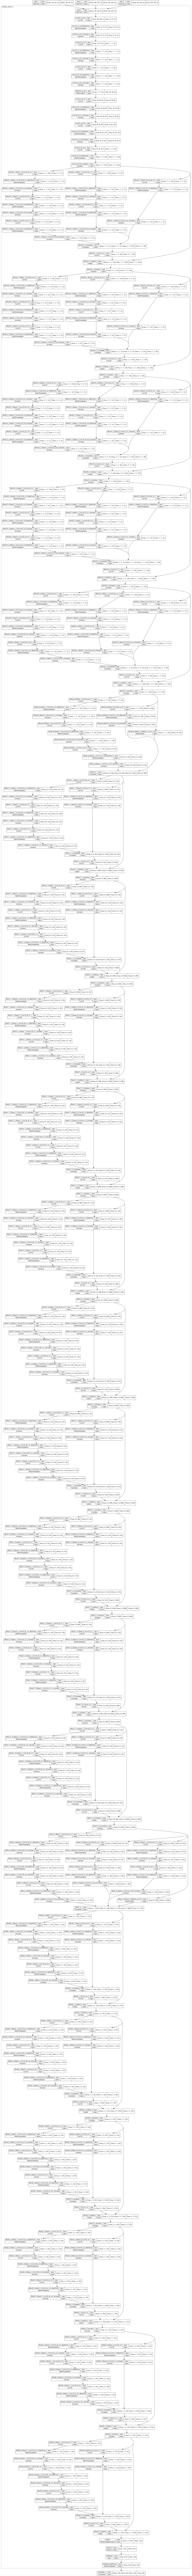

In [ ]:
from keras.layers.merge import Concatenate
triplet_model_out1 = Concatenate()([FRmodel(triplet_model_anchor), FRmodel(triplet_model_positive), FRmodel(triplet_model_negative)])
triplet_model1 = keras.Model([triplet_model_anchor, triplet_model_positive, triplet_model_negative], [triplet_model_out1])
triplet_model1.summary()
display(tf.keras.utils.plot_model(triplet_model1, dpi = 70, show_shapes = True, expand_nested = True))
triplet_model1.compile(optimizer = tf.keras.optimizers.Adam(), loss = triplet_loss)


In [ ]:
history = triplet_model1.fit(gen_batch(batch_size = 64), steps_per_epoch = 150, epochs = 15)

Epoch 1/15
150/150 [==============================] - 19s 34ms/step - loss: 0.2084
Epoch 2/15
150/150 [==============================] - 5s 34ms/step - loss: 0.3612
Epoch 3/15
150/150 [==============================] - 5s 34ms/step - loss: 0.2933
Epoch 4/15
150/150 [==============================] - 5s 34ms/step - loss: 0.3048
Epoch 5/15
150/150 [==============================] - 5s 33ms/step - loss: 0.3436
Epoch 6/15
150/150 [==============================] - 5s 34ms/step - loss: 0.2214
Epoch 7/15
150/150 [==============================] - 5s 34ms/step - loss: 0.3822
Epoch 8/15
150/150 [==============================] - 5s 34ms/step - loss: 0.2698
Epoch 9/15
150/150 [==============================] - 5s 33ms/step - loss: 0.5474
Epoch 10/15
150/150 [==============================] - 5s 34ms/step - loss: 0.2656
Epoch 11/15
150/150 [==============================] - 5s 34ms/step - loss: 0.3362
Epoch 12/15
150/150 [==============================] - 5s 34ms/step - loss: 0.1533
Epoch 13/15


In [ ]:
FRmodel.trainable = True
triplet_model1.compile(optimizer = tf.keras.optimizers.Adam(), loss = triplet_loss)

In [ ]:
history = triplet_model1.fit_generator(gen_batch(batch_size = 64), steps_per_epoch = 500, epochs = 32)

Epoch 1/32
  3/500 [..............................] - ETA: 16s - loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


500/500 [==============================] - 17s 34ms/step - loss: 0.2879
Epoch 2/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3592
Epoch 3/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3418
Epoch 4/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3040
Epoch 5/32
500/500 [==============================] - 17s 33ms/step - loss: 0.4238
Epoch 6/32
500/500 [==============================] - 17s 34ms/step - loss: 0.2901
Epoch 7/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3446
Epoch 8/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3562
Epoch 9/32
500/500 [==============================] - 17s 34ms/step - loss: 0.2873
Epoch 10/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3029
Epoch 11/32
500/500 [==============================] - 17s 34ms/step - loss: 0.4349
Epoch 12/32
500/500 [==============================] - 17s 34ms/step - loss: 0.3192
Epoch 13/32


In [ ]:
x = img_to_encoding('/content/drive/MyDrive/FakeSignature2/WhatsApp Image 2022-02-11 at 20.27.44 (1).jpeg', FRmodel)
y = FRmodel.predict(np.expand_dims(true_signature["Itzik Yeyni"][2],0))
z = FRmodel.predict(np.expand_dims(true_signature["Itzik Yeyni"][0],0))
print(np.linalg.norm(y - x))
print()
print(np.linalg.norm(y - z))
print(np.sum(np.square(y - x), axis=-1))
print(np.sum(np.square(y - z), axis=-1))


3.0924764

1.3572369
[9.56341]
[1.842092]


In [ ]:
x = FRmodel.predict(np.expand_dims(true_signature['Itzik Yeyni'][0], 0))
y = FRmodel.predict(np.expand_dims(true_signature['Itzik Yeyni'][1], 0))
z = FRmodel.predict(np.expand_dims(true_signature['Or Yeyni'][0], 0))
print(np.linalg.norm(x - y), np.linalg.norm(x - z))
print(np.sum(np.square(x - y), axis=-1))
print()
print(np.sum(np.square(x - z), axis=-1))

1.6907823 2.6069844
[2.8587444]

[6.796368]


In [ ]:
base_model = tf.keras.applications.ResNet50(weights="imagenet", input_shape=(160,160,3),include_top=False)
base_model.trainable = False

In [ ]:
from tensorflow.python.ops.gen_dataset_ops import optional_get_value
from tensorflow.python import training
inputs = keras.Input(shape = (160,160,3))
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(128, activation = 'sigmoid')(x)
modelX = keras.Model(inputs, outputs)
modelX.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_23 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 262,272
Non-trainable params: 23,587,712
_________________________________________________________________


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_38 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_39 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                         

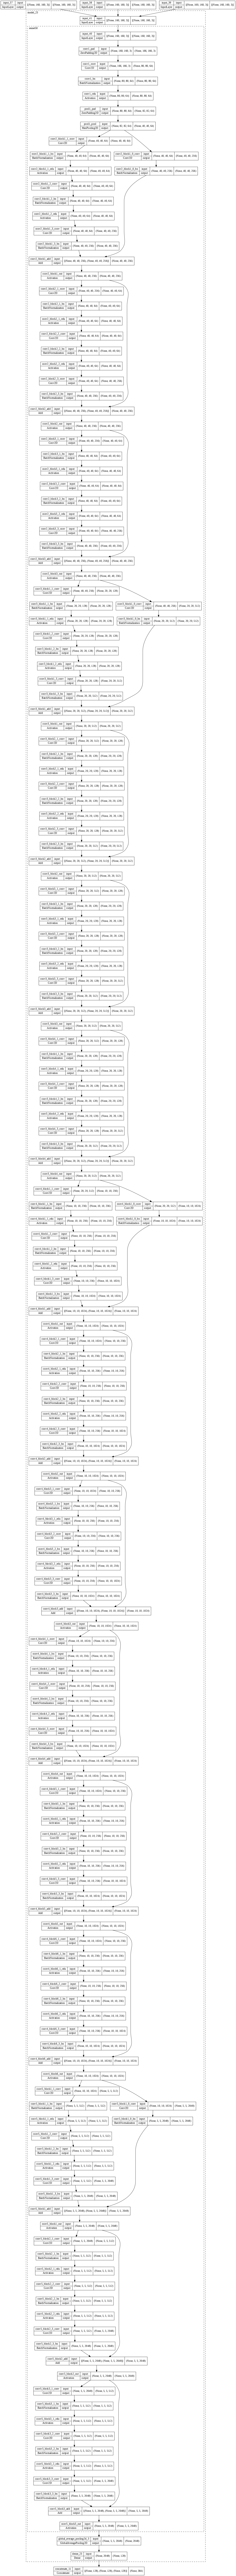

In [ ]:
from keras.layers.merge import Concatenate
triplet_model_out1 = Concatenate()([modelX(triplet_model_anchor), modelX(triplet_model_positive), modelX(triplet_model_negative)])
triplet_modelX = keras.Model([triplet_model_anchor, triplet_model_positive, triplet_model_negative], [triplet_model_out1])
triplet_modelX.summary()
display(tf.keras.utils.plot_model(triplet_modelX, dpi = 70, show_shapes = True, expand_nested = True))
triplet_modelX.compile(optimizer = tf.keras.optimizers.Adam(), loss = triplet_loss)

In [ ]:
history = triplet_modelX.fit(gen_batch(), steps_per_epoch = 250, epochs = 15)

Epoch 1/15
250/250 [==============================] - 18s 42ms/step - loss: 0.0541
Epoch 2/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0263
Epoch 3/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0187
Epoch 4/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0124
Epoch 5/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0085
Epoch 6/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0153
Epoch 7/15
250/250 [==============================] - 10s 42ms/step - loss: 0.0060
Epoch 8/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0065
Epoch 9/15
250/250 [==============================] - 11s 43ms/step - loss: 0.0039
Epoch 10/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0029
Epoch 11/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0022
Epoch 12/15
250/250 [==============================] - 11s 42ms/step - loss: 0.0035
E

In [ ]:
base_model.trainable = True
triplet_modelX.compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = triplet_loss)
history = triplet_modelX.fit_generator(gen_batch(), steps_per_epoch = 500, epochs = 32)

Epoch 1/32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


500/500 [==============================] - 59s 94ms/step - loss: 1.8840
Epoch 2/32
500/500 [==============================] - 47s 93ms/step - loss: 0.2820
Epoch 3/32
500/500 [==============================] - 46s 93ms/step - loss: 0.3260
Epoch 4/32
500/500 [==============================] - 47s 93ms/step - loss: 0.6709
Epoch 5/32
500/500 [==============================] - 46s 93ms/step - loss: 0.1764
Epoch 6/32
500/500 [==============================] - 47s 93ms/step - loss: 0.1486
Epoch 7/32
500/500 [==============================] - 47s 93ms/step - loss: 0.0971
Epoch 8/32
500/500 [==============================] - 47s 93ms/step - loss: 0.0360
Epoch 9/32
500/500 [==============================] - 47s 93ms/step - loss: 0.0908
Epoch 10/32
500/500 [==============================] - 46s 93ms/step - loss: 7.8367e-04
Epoch 11/32
500/500 [==============================] - 47s 93ms/step - loss: 0.0712
Epoch 12/32
500/500 [==============================] - 47s 93ms/step - loss: 0.1469
Epoch 13

In [ ]:
x = modelX.predict(np.expand_dims(true_signature['Itzik Yeyni'][0], 0))
y = modelX.predict(np.expand_dims(true_signature['Itzik Yeyni'][1], 0))
z = modelX.predict(np.expand_dims(true_signature['Or Yeyni'][0], 0))
print(np.linalg.norm(x - y), np.linalg.norm(x - z))
print(np.sum(np.square(x - y), axis=-1))
print(np.sum(np.square(x - z), axis=-1))

2.5441487 3.0189705
[6.4726925]
[9.114183]


In [ ]:
for i in range(5):
  x = modelX.predict(np.expand_dims(true_signature['Itzik Yeyni'][i], 0))
  y  = modelX.predict(np.expand_dims(true_signature['Itzik Yeyni'][i+1], 0))
  z = modelX.predict(np.expand_dims(true_signature['Or Yeyni'][2], 0))
  print(np.linalg.norm(x - y))
  print(np.linalg.norm(x - z))
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(x,y)),axis=-1)
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(x,z)),axis=-1)
  basic_loss = tf.add(tf.subtract(pos_dist,neg_dist), 0.3)
  loss = tf.reduce_sum(tf.maximum(basic_loss,0))
  print(loss)
  print()

2.5441487
2.8119578
tf.Tensor(0.0, shape=(), dtype=float32)

2.6040926
2.8595603
tf.Tensor(0.0, shape=(), dtype=float32)

2.398756
3.0184708
tf.Tensor(0.0, shape=(), dtype=float32)

3.5924463
2.741683
tf.Tensor(5.688845, shape=(), dtype=float32)

3.1424282
2.966015
tf.Tensor(1.37761, shape=(), dtype=float32)



In [ ]:
#FRmodel.save("/content/drive/MyDrive/FRmodel")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FRmodel/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Xmodel/assets


In [ ]:
modelX.save("/content/drive/MyDrive/Xmodel")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Xmodel/assets


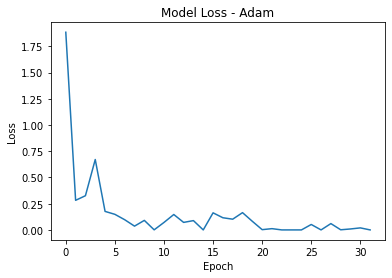

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss - Adam')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()